# Calibration Procedure

In [1]:
scan_filename = '/homelocal/rhoms/tmp/clear_data/20180420.dat'
scan_id_calib = 244086
user_roi_low = 650
user_roi_high = 900
use_user_roi = False
user_noise_percent = 2.5

Results of the original library (MacroServer Logs)

```
BL22/DOOR/01.Macro[mcalib]: scan id : 244086
BL22/DOOR/01.Macro[mcalib]: scan dir : /beamlines/bl22/inhouse/18_04_Laura
BL22/DOOR/01.Macro[mcalib]: scan file : 20180420.dat
BL22/DOOR/01.Macro[mcalib]: output file : 
BL22/DOOR/01.Macro[mcalib]: 
mythen_post.py mcalib 244086 /beamlines/bl22/inhouse/18_04_Laura 20180420.dat -a  
BL22/DOOR/01.Macro[mcalib]: open dat /beamlines/bl22/inhouse/18_04_Laura 20180420.dat
gauss_function None None None
('a and b', -0.085764840922680816, 76.44588904356003)
Optimization terminated successfully.
         Current function value: 0.000775
         Iterations: 232
         Function evaluations: 390
('* Order :', 3.0)
* Linear regression
('    - k :', 1.5002054909999969)
('    - a clear theory, b clear theory : ', -0.13540972822607902, 7058.0137825667543)
('    - a clear exp, b clear exp : ', -0.13310574689255464, 7161.2865012657739)
('    - a mythen exp, b mythen exp : ', -0.088725009801043919, 78.850243253625408)
('    - ROI:', 600, 1000)
* Calibration 2D
('    - Dispersion shape : ', 'gauss_function')
('    - p0, i0 : ', 783.34017156671723, 9.3483788538169961)
('    - p_std, i_std : ', 3.2176908204922814, 3.3292291473872786)
('    - Resolution (eV), Dispersion (eV) : ', 0.42829313993094209, 4.9945278477076336)
* Calibration 1D
('    - Dispersion shape : ', 'gauss_function')
('    - p0, i0 : ', array([211726, 211727, 211728, 211729, 211730, 211731, 211732, 211733,
       211734, 211735, 211736, 211737, 211738, 211739, 211740, 211741,
       211742, 211743, 211744, 211745]), 9.4000399989000183)
('    - p0_std, i_std : ', 34.342187448080871, 3.1284128602224319)
('    - Resolution (eV), Dispersion (eV) : ', 0.39833630221298472, 0.38067458778455648)
('*  Theta offset', 0.012129332177124752)
('entering the spec file', ['Emythen', 'Yresolution_Emythen', 'pixels', 'Y_Emythen'])
saved in spec file ...
('entering the spec file', ['index', 'Ein', 'Y_Ein', 'Yresolution_Ein'])
saved in spec file ...
```


Import libraries

In [2]:
import sys
import numpy as np
from scipy.optimize import fmin, curve_fit
sys.path.append('/homelocal/rhoms/develop/pycharm/MythenPostProcessing/')
sys.path.append('/homelocal/rhoms/develop/pycharm/Crystal/')
from bl22mythenlib.specreader import read_scan



Preare matplotlib to plot inline

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot(data):
    if len(data.shape) == 1:
        plt.plot(data)
    else:
        for i in data:
            plt.plot(i)


# Read data from the spec file


In [4]:
# Beamline Channels names
M_RAW = 'm_raw'
ENERGY = 'energyc'
IO = 'n_i0_1'
CBRAGG = 'clear_bragg'
CEOUT = 'ceout'
CAZ = 'caz'

# Mythen
PIXEL_SIZE = 50e-6
BAD_PIXEL = 1140

def get_mythen_data(data):
    """
    Method to extract the Mythen data from the raw data. It normalizes the
    Mythen data by the I0 and remove the bad channels.
    :param data: Dictionary with the raw data
    :type: dict
    :return: Mythen date pre-prosed
    :type: numpy.array
    """

    m_raw = np.array(data[M_RAW])
    i0 = np.array(data[IO])

    # Remove bad pixels
    m_raw = m_raw[:, range(BAD_PIXEL)]

    # Normalize the mythen data
    m_norm = (m_raw / i0[:, np.newaxis]) * i0.mean()
    return m_norm

## Read data from file and normilze by I0

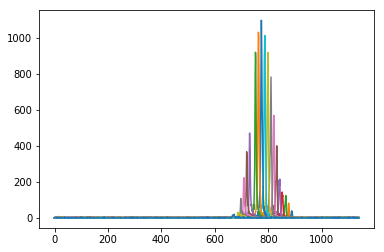

In [5]:
scan_data, scan_snapshot = read_scan(scan_filename, scan_id_calib)
m_data = get_mythen_data(scan_data)
plot(m_data)

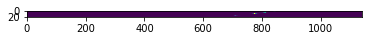

In [6]:
img = plt.imshow(m_data)

# Calculate a and b for energy scale

## Lineal regression
### normalize the data

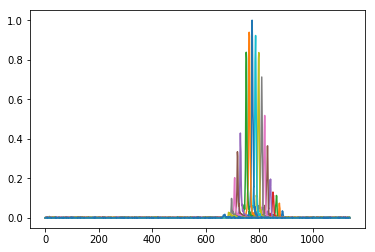

In [7]:
def normalize(x, scale_min=0., scale_max=1.):
    """
    Normalize the signal by the MaxMin Scaler method
    Xmin = min(X)
    Xmax = max(X)
             X - Xmin
    Xnorm = -------------
             Xmax - Xmin

    Additional it is possible to change the scale
    Xnorm_scaled = (scale_max - scale_min) * Xnorm + scale_min

    :param x: Data vector
    :type: numpy.array
    :param scale_min: Minimum value of the new scale
    :type: float
    :param scale_max: Maximum value of the new scale
    :type: float

    :return: Normalized and rescaled data vector
    :type: numpy.array
    """
    x_min = float(x.min())
    x_max = float(x.max())
    if x_max == x_min:
        return x
    x_norm = (x - x_min) / (x_max - x_min)

    x_rescaled = (scale_max - scale_min) * x_norm + scale_min

    return x_rescaled


m_norm = normalize(m_data)
plot(m_norm)

### remove values lower than threshold

Use as threshold 70% of the signal 

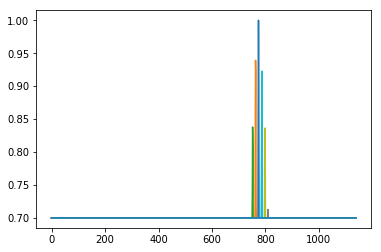

In [8]:
m_clipped = m_norm.clip(min=0.7, max=1)
plot(m_clipped)


### Calculate the probability distribution

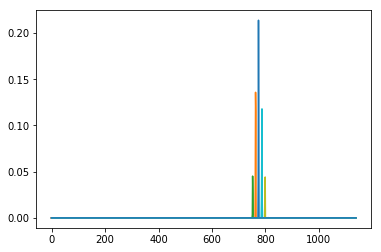

In [9]:
def probability_distribution(x, order=2):
    """
    Calculate the probability distribution
    :param x: Data vector
    :type: numpy.array
    :param order:
    :type: int
    :return:
    """
    x = normalize(x, 0., 1.)
    x = x ** order
    x = x / x.sum()
    return x


m_pd = probability_distribution(m_clipped)
plot(m_pd)

### Calculate the marginal distribution of probability

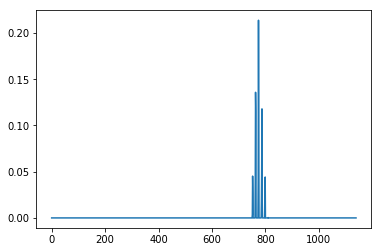

In [10]:
x_pd = m_pd.sum(axis=0)
plot(x_pd)

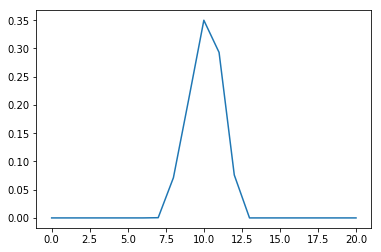

In [11]:
y_pd = m_pd.sum(axis=1)
plot(y_pd)

### Calculate the mean values

773.6708867605603


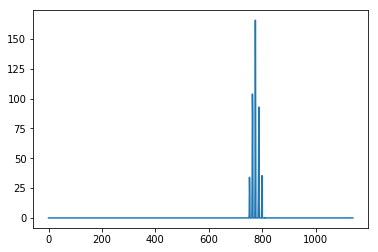

In [12]:
x_idx = np.arange(m_pd.shape[1])
x_temp = x_pd * x_idx
plot(x_temp)
x_mean = x_temp.sum()
print(x_mean)

10.092128514031208


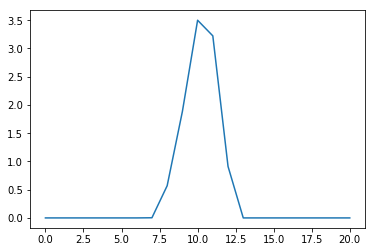

In [13]:
y_idx = np.arange(m_pd.shape[0])
y_temp = y_pd * y_idx
plot(y_temp)
y_mean = y_temp.sum()
print(y_mean)

598713.6554071589


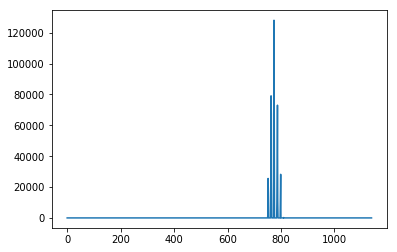

In [14]:
x2_temp = x_pd * x_idx**2
plot(x2_temp)
x2_mean = x2_temp.sum()
print(x2_mean)

In [15]:
y2_mean = (y_pd * y_idx**2).sum()
print(y2_mean)

102.93723989865079


7795.37735129873


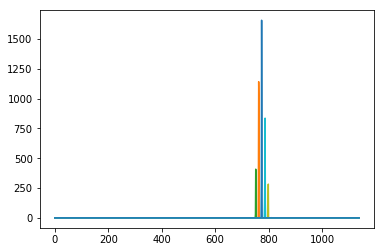

In [16]:
xy_idx = y_idx.reshape((y_idx.size,1)) * x_idx
xy_temp = m_pd * xy_idx
plot(xy_temp)
xy_mean = xy_temp.sum()
print(xy_mean)

### Calculate a, b and standard desviations 

In [17]:
a = (xy_mean - x_mean *y_mean) / (x2_mean-x_mean**2)
print(a)

-0.08576484092311305


In [18]:
b = (y_mean - a * x_mean)
print(b)
# we have to shift to compensate pixel number 1 at index 0
# y = ax + b --> y = a(x'-1) + b <==> ax' -a + b
b = b - a
print('b after corrected: ', b)

76.44588904389447
b after corrected:  76.53165388481759


In [19]:
x_std = np.sqrt(x2_mean - x_mean**2)
print(x_std)

12.12494891895186


In [20]:
y_std = np.sqrt(y2_mean - y_mean**2)
print(y_std)

1.0422005348919332


### Calculate AutoROIs

ROI low:684 high:889


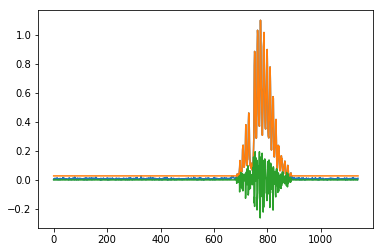

In [21]:
# Concatenate all images
m_roi_x = m_norm.sum(axis=0)
plot(m_roi_x)
# Reduce noise
noise_level = m_roi_x.max() * user_noise_percent/100
m_roi_x_clipped = m_roi_x.clip(min=noise_level) 
plot(m_roi_x_clipped)
diff_m_roi = np.diff(np.diff(m_roi_x_clipped))
plot(diff_m_roi)
diff_norm = normalize(diff_m_roi)
r = np.where(diff_norm != diff_norm.mean())[0]

auto_roi_low = r[0]
auto_roi_high = r[-1]

if use_user_roi:
    roi_low = user_roi_low
    roi_high = user_roi_high
else:
    roi_low = auto_roi_low
    roi_high = auto_roi_high
print('ROI low:{0} high:{1}'.format(roi_low, roi_high))

## Calculate the 2D dispersion


In [22]:
def dispersion_2d(a, x0, y0, alpha, beta, X, Y):
    XX = X - x0
    YY = Y - y0
    arg = 0.5 * (((XX - YY / a) / alpha) ** 2) + 0.5 * ((YY / beta) ** 2)
    z = 1 / (2 * np.pi * alpha * beta) * np.exp(-arg)
    return z / z.sum()

In [23]:
# The original code use only the noise form 0 to a pixel_limit_noise 600. 
# Refactor to use the data out of the roi
low_noise = m_data[:,0:roi_low].mean()
high_noise = m_data[:,roi_high:BAD_PIXEL].mean()
noise = (low_noise + high_noise) / 2
print(noise)

0.33753577513557137


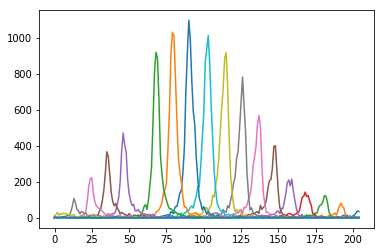

In [24]:
# mythen data without noise
m_wn = m_data - noise
# apply rois
m_wroi = m_wn[:,roi_low:roi_high]
plot(m_wroi)


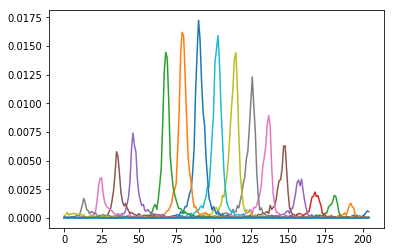

In [25]:
d = m_wroi/m_wroi.sum()
plot(d)

In [26]:
X, Y = np.meshgrid(np.arange(m_wroi.shape[1]),np.arange(m_wroi.shape[0]))
cost = lambda v: ((dispersion_2d(a, x_mean, y_mean, 
                                 x_std, y_std, X, Y)-d)**2).sum()
new_a, new_x_mean, new_y_mean, new_x_std, new_y_std = fmin(cost, [a, 
                                                                  x_mean, 
                                                                  y_mean, 
                                                                  x_std, 
                                                                  y_std])

new_b = y_mean - new_a * new_x_mean
print('\nNew values','\na: ', new_a, '\nb', new_b, '\nx_mean: ', new_x_mean, '\ny_mean: ', new_y_mean)


New values 
a:  -0.08576484092311305 
b 76.44588904389447 
x_mean:  773.6708867605603 
y_mean:  10.092128514031208


/home/rhoms/miniconda/envs/mpp/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


## Set a and b
Use the 2d dispersion fitting as linear interpolation of the pixel to enegy equation

In [27]:
# extract energy
energies = np.array(scan_data[ENERGY])
k = (energies[-1] - energies[0]) / float(len(energies) - 1)

if np.abs((new_a - a)/a) < 0.1:
    # Use 2D dispection fitting
    a = new_a
    b = new_b
    x_mean = new_x_mean
    y_mean = new_y_mean

energy_a = k * a
energy_b = k * b + energies[0]
print('Scale energy formula energy = {0} * pixel + {1}'.format(energy_a, energy_b))

def pixel2energy(p):
    return energy_a * p + energy_b

def energy2pixel(e):
    return (e - energy_b)/ energy_a

Scale energy formula energy = -0.12866488528759545 * pixel + 7157.679475878027


# Calculate p0 and e0

In [28]:
def get_statistics(x, p, order=2):
    p = probability_distribution(p, order=order)
    Xmean = (p * x).sum()
    Xstd = np.sqrt((p * x ** 2).sum() - Xmean ** 2)
    return Xmean, Xstd

def get_best_fit(x, y, func):
    x_mean, x_std = get_statistics(x, y, order=4)
    first_point = [y.mean(), x_mean, x_std]
    try:     
        popt, pcov = curve_fit(func, x, y, p0=first_point)
        x_max, x_mean, x_std = popt
    except:
        x_max, x_mean, x_std = first_point
    return x_max, x_mean, x_std

def gauss_function(x, a, x0, sigma):
    sigma = max(sigma, 1)
    return a*np.exp(-(x-x0)*(x-x0)/(2*sigma**2))


In [29]:
x = np.arange(m_wroi.shape[1])
disp_exp = m_wroi.max(axis=0)
x_max, x_mean, x_std = get_best_fit(x, disp_exp, gauss_function)
print('x_mean: ', x_mean, '\nx_std', x_std)

x_mean:  98.10728491155255 
x_std 34.32482218113426


In [30]:
p0 = int(x_mean + roi_low)
e0 = pixel2energy(p0)
print('p0:', p0,'\ne0:',e0)

p0: 782 
e0: 7057.063535583127


# Results

In [31]:
print('p0:       ', p0)
print('e0:       ', e0)

print('energy_a: ', energy_a)
print('energy_b: ', energy_b)
print('use AutoROIs:', not(use_user_roi))
print('roi:      ', roi_low, roi_high)

p0:        782
e0:        7057.063535583127
energy_a:  -0.12866488528759545
energy_b:  7157.679475878027
use AutoROIs: True
roi:       684 889


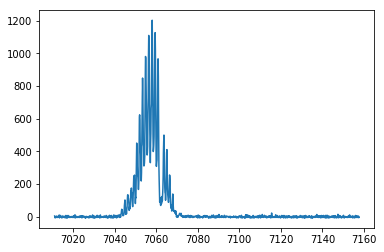

In [58]:
energy_scale = pixel2energy(range(1140))
scan_sum = m_wn.sum(axis=0)
plt.plot(energy_scale, scan_sum)



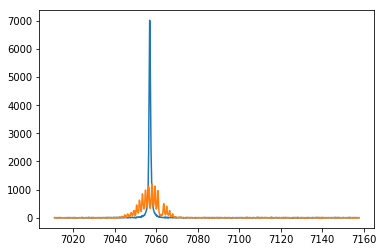

In [60]:
p0_e = energy2pixel(energies).astype(int)
p0_delta = p0_e - p0
min_scale = 0 
max_scale = BAD_PIXEL 
pixel_scale = np.array(range(min_scale, max_scale))
resolution_scan_sum = np.zeros(pixel_scale.shape[0])
for p0_d, i in zip(p0_delta, m_wn):
    min_pixel = abs(p0_d)
    max_pixel = BAD_PIXEL - min_pixel
    if p0_d > 0:
        resolution_scan_sum[0:max_pixel] = resolution_scan_sum[0:max_pixel] + i[min_pixel:BAD_PIXEL]
    else:
        resolution_scan_sum[min_pixel: BAD_PIXEL] = resolution_scan_sum[min_pixel: BAD_PIXEL] + i[0: max_pixel]

energy_scale = pixel2energy(pixel_scale)
plt.plot(energy_scale, resolution_scan_sum)
plt.plot(energy_scale, scan_sum)

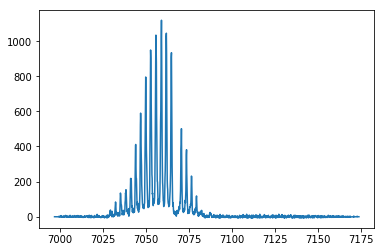

In [33]:
p0_e = energy2pixel(energies).astype(int)
p0_delta = p0_e - p0
min_scale = 0 + p0_delta.min()
max_scale = BAD_PIXEL + p0_delta.max()
pixel_scale = np.array(range(min_scale, max_scale))
scan_sum = np.zeros(pixel_scale.shape[0])
for p0_d, i in zip(p0_delta, m_wn):
    min_pixel = 0 + p0_d + np.abs(min_scale)
    max_pixel = min_pixel + BAD_PIXEL
    scan_sum[min_pixel:max_pixel] = scan_sum[min_pixel:max_pixel] + i

energy_scale = pixel2energy(pixel_scale)
plt.plot(energy_scale, scan_sum)